In [1]:
# import libraries
import math
import numpy
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch
import random
import time
from sklearn import preprocessing
import scipy.io

from net import MainNet
from dynamics.robot_selector import robot_selector
from dynamics.data_gen_robot import data_gen_robot_multi

In [2]:
robot_type = "3R"
modality = "3D"

In [3]:
# robot pars
robot_pars = {}
robot_pars['m'] = 0.6
robot_pars['l'] = 1
robot_pars['I'] = (robot_pars['m']/(robot_pars['l']**2))*np.diag([0,1,1])/12
robot_pars['G'] = 1
robot_pars['B'] = 0
robot_pars['T'] = 0

In [4]:
# robot parameters changed
robot_pars_changed = {}
robot_pars_changed['m'] = 0.6+(-5*0.06)
robot_pars_changed['l'] = 1.0   # 1
robot_pars_changed['I'] = (robot_pars_changed['m']/(robot_pars_changed['l']**2))*np.diag([0,1,1])/12
robot_pars_changed['G'] = 1
robot_pars_changed['B'] = 0
robot_pars_changed['T'] = 0

robot_pars_changed['state_noise'] = True
robot_pars_changed['state_noise_type'] = 'gaussian' # constant, sinosoidal, gaussian, 'random'
SNR_DB_state = 25
robot_pars_changed ['SN_state'] = (10**(SNR_DB_state/20))

robot_pars_changed ['ext_torque'] = False
SNR_DB_input = 10
robot_pars_changed ['ext_torque_type'] = 'gaussian' # constant, sinosoidal, gaussian, 'random'
robot_pars_changed ['SN_input'] = (10**(SNR_DB_input/20))

In [5]:
robot_name = robot_type + "_" + modality
robot = robot_selector(robot_name,robot_pars)
robot_changed = robot_selector(robot_name,robot_pars_changed)

In [6]:
dt = 0.01  #time step
num_train = 120  # no. of training examples
num_val = int(0.25 * num_train)  # no of testing examples
num_traj = num_train + num_val  #no of trajectories
num_snaps = 100  # no. of snapshots
controller = 'controller'  # controller used or not for data generation
num_joints = robot.random_q().shape[0]
num_states = 2 * robot.random_q().shape[0]
num_inputs = num_joints
T = np.linspace(0, num_snaps * dt, num_snaps)

In [7]:
state_data,_, _, _, input_data = data_gen_robot_multi(dt,num_traj,num_snaps, robot, robot_changed, robot_pars_changed, controller)

In [8]:
state_data.shape, input_data.shape

((150, 100, 6), (150, 99, 3))

In [9]:
num_states = state_data.shape[2]
num_joints = int(num_states/2)
ctrl_dim = input_data.shape[2]

num_traj = state_data.shape[0]
num_snaps = input_data.shape[1]

In [10]:
#compute acceleration using Forward difference scheme
accln = (state_data[:,1:,num_joints:] - state_data[:,:-1,num_joints:])/dt

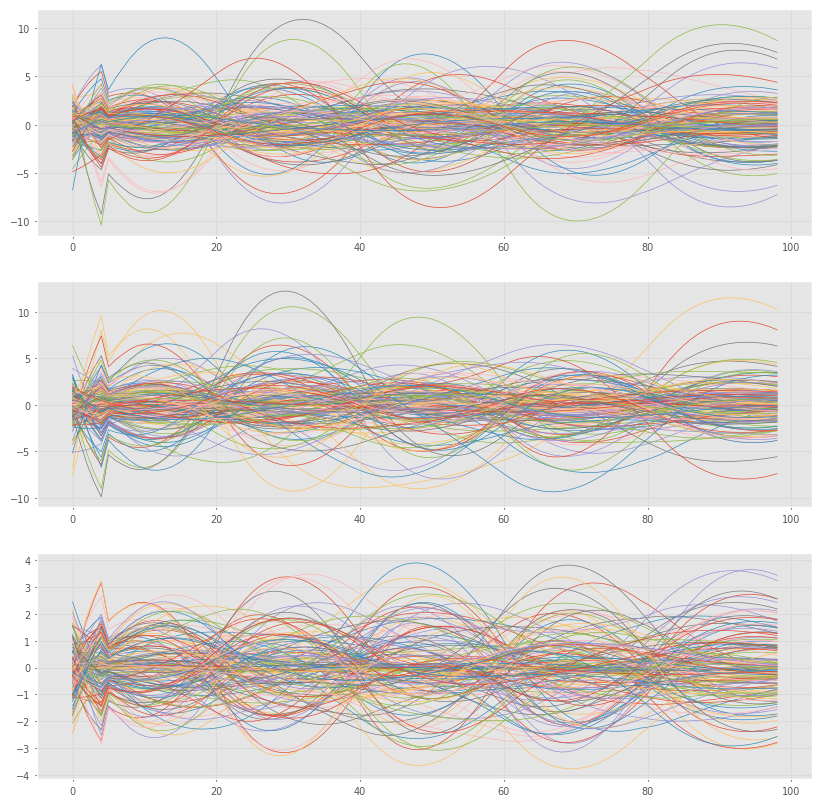

In [11]:
plt.figure(figsize = (10,10))
for i in range(num_traj):
    for j in range(num_joints):
        plt.subplot(3,1,j+1)
        plt.plot(accln[i,:,j])
plt.show()

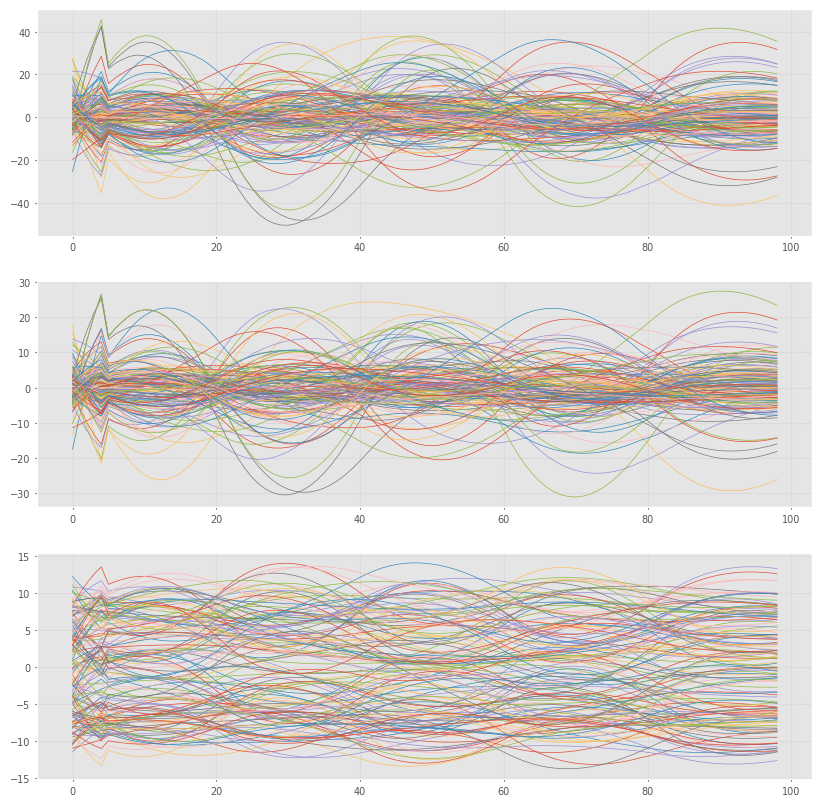

In [12]:
plt.figure(figsize = (10,10))
for i in range(num_traj):
    for j in range(num_joints):
        plt.subplot(3,1,j+1)
        plt.plot(input_data[i,:,j])
plt.show()

In [13]:
# define the parameters of the network
FC_neurons = 100
Conv_RELU = 100
Conv = 200
net_params = {}
net_params['num_joints'] = num_joints
net_params["input_dim"] = num_states
net_params['output_dim'] = num_inputs
net_params['FC_layers'] = [FC_neurons, FC_neurons, num_joints]
net_params['Conv_layers_RELU'] = [3, Conv_RELU, [1, 1]] # [in_channels, out_channels, kernel_size (height), width]
net_params['Conv_layers'] = [Conv_RELU, Conv, [1, 1]]
net_params['dim_layer_a'] = Conv
net_params['optimizer'] = 'adam'
net_params['standardize'] = 'True'
net_params['l1_reg'] = 2e-1
net_params['l2_reg'] = 2e-1
net_params['lr'] = 1e-4
net_params['epochs'] = 500
net_params['batch_size'] = 256
net_params['activation_FC'] = 'relu'
net_params['activation_Conv'] = 'relu'

In [14]:
X = np.concatenate((state_data[:,:-1,:], accln), axis = 2)
xs_train, us_train = X[:num_train,:,:], input_data[:num_train,:,:]
xs_val, us_val = X[num_train:,:,:], input_data[num_train:,:,:]

In [15]:
xs_train.shape, us_train.shape

((120, 99, 9), (120, 99, 3))

In [19]:
from net import TrainNet
# from torchviz import make_dot
import hiddenlayer as hl
from core.util import fit_standardizer

In [20]:
Train = True
if Train:
    network = MainNet(net_params)
    train_network = TrainNet(network)
    train_network.model_pipeline(xs_train, us_train, xs_val, us_val)
    torch.save(train_network,'saved_network/'+'num_traj'+str(num_train)+'cnn_arch.pth')
else:
    train_network = torch.load('NN_arch.pth')
    network = train_network.net

NameError: name 'standardizer' is not defined

In [ ]:
#plot the loss convergence with epochs
epochs = np.arange(0, net_params['epochs'])

plt.figure(figsize=(15,8))
plt.plot(epochs, train_network.train_loss_hist, color='tab:orange', label='Training loss')
plt.plot(epochs, train_network.val_loss_hist, color='tab:blue', label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [ ]:
index = 9
x_test = X[index,:,:]
y_test = input_data[index,:,:]

In [ ]:
#comparison between actual and predicted trajectory 
Train = False
y_net = np.zeros((num_snaps,num_joints))
x_test_flat, y_test_flat = network.process_data(x_test.reshape((1,num_snaps,9)), y_test.reshape(1,num_snaps,3))
x_test_std = network.standardize_data(x_test_flat)

for i in range(x_test.shape[0]):
    y_net[i,:] = network.forward(torch.from_numpy(x_test_std[i,:]).float().reshape(1,-1), Train)

In [ ]:
#Plot predicted and actual trajectories
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(y_test_flat[0,:], label = 'reference traj')
plt.plot(y_net[:,0],'--', label = 'pred traj')
plt.legend()

plt.subplot(3,1,2)
plt.plot(y_test_flat[1,:], label = 'reference traj')
plt.plot(y_net[:,1],':', label = 'pred traj')
plt.legend()

plt.subplot(3,1,3)
plt.plot(y_test_flat[2,:], label = 'reference traj')
plt.plot(y_net[:,2],'-.', label = 'pred traj')
plt.legend()
plt.show()

In [ ]:
"""CONTROL AND ADAPTATION"""

In [ ]:
# generate the reference trajectory
dt = 0.01
t_end = 30
t_eval = np.arange(0,t_end,dt)
num_steps = t_eval.shape[0]
theta_d = np.zeros((num_steps, num_joints))
theta_dot_d = np.zeros((num_steps, num_joints))
theta_ddot_d = np.zeros((num_steps, num_joints))

num_cycles = t_end/10
arg = np.linspace(0, num_cycles*2*np.pi,num_steps)


for i in range(num_steps):
    theta_d[i,:] = -0.5*np.array([np.sin(2*arg[i]), np.sin(2*arg[i]), np.sin(2*arg[i])])

    theta_dot_d[i,:] = -0.5*np.array([(2*arg[-1]/t_end)*np.cos(2*arg[i]), (2*arg[-1]/t_end)*np.cos(2*arg[i]), (2*arg[-1]/t_end)*np.cos(2*arg[i])])

    theta_ddot_d[i,:] = -0.5*np.array([-((2*arg[-1]/t_end)**2)*np.cos(2*arg[i]), -((2*arg[-1]/t_end)**2)*np.cos(2*arg[i]), -((2*arg[-1]/t_end)**2)*np.cos(2*arg[i])])


tau = np.zeros((num_steps, num_joints))

theta_t = np.zeros_like(theta_d)
theta_dot_t = np.zeros_like(theta_dot_d)
theta_ddot_t = np.zeros_like(theta_dot_d)

Error = np.zeros((num_steps,num_joints))
Error_dot = np.zeros((num_steps, num_joints))

a = np.zeros((Conv,num_steps))
a[:,0] = network.A_weight().reshape(-1)

In [ ]:
#Plot reference trajectories
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(theta_d[:,0], label = 'reference traj')
plt.legend()

plt.subplot(3,1,2)
plt.plot(theta_d[:,1], label = 'reference traj')
plt.legend()

plt.subplot(3,1,3)
plt.plot(theta_d[:,2], label = 'reference traj')
plt.legend()
plt.show()

In [ ]:
#adaptation and control performance
k = 9
P = 0.01
Ks = np.diag(np.array([0.1, 0.1, 0.1]))
L = np.diag(np.array([2, 2, 2]))

adapt_freq = 500
train_network = torch.load('NN_arch.pth')

begin_time = time.time()
adaptation_time = 0
control_time = 0
for i in range(num_steps-1):
    t1 = time.time()
    error = (theta_t[i,:] - theta_d[i,:]).reshape(-1,1)
    error_dot = (theta_dot_t[i,:] - theta_dot_d[i,:]).reshape(-1,1)
    s =  error_dot + L @ error
    theta_dot_r = theta_dot_d[i,:].reshape(-1,1) - L @ error
    theta_ddot_r = theta_ddot_d[i,:].reshape(-1,1) - L @ error_dot

    input_vec = np.concatenate((theta_t[i,:],theta_dot_t[i,:], theta_dot_r.reshape(-1,), theta_ddot_r.reshape(-1,)))

    input_vec_tensor = torch.from_numpy(input_vec.reshape(1,-1)).float()
    Y_out = network.Y_out(input_vec_tensor)
    a_dot = -P * Y_out.squeeze() @ s
    t2 = time.time()
    tau[i,:] = (Y_out.squeeze().T @ a[:,i].reshape(-1,1) - Ks @ s - k * np.sign(s)).reshape(-1,)
    t3 = time.time()
    a[:,i+1] = a[:,i] + a_dot.reshape(-1,) * dt
    t4 = time.time()
    theta_ddot_t[i,:] = robot_changed.accel(theta_t[i,:], theta_dot_t[i,:], tau[i,:]).reshape(-1,)
    theta_dot_t[i+1,:] = theta_ddot_t[i,:] * dt + theta_dot_t[i,:]
    theta_t[i+1,:] = theta_t[i,:] + theta_dot_t[i+1,:]*dt
    
    Error[i,:] = error.reshape(-1,)
    Error_dot[i,:] = error_dot.reshape(-1,)
    t5 = time.time() 
    """ADAPTATION"""
    if i % adapt_freq==0 and i!=0:
        adapt_params = {}
        adapt_params['epochs'] = 10
        adapt_params['batch_size'] = adapt_freq 
        
        x_adapt = np.concatenate((theta_t[i-adapt_freq:i,:],theta_dot_t[i-adapt_freq:i,:], theta_ddot_t[i-adapt_freq:i,:]), axis = 1)
        u_adapt = tau[i-adapt_freq:i,:]
        train_network.model_pipeline_adapt(x_adapt, u_adapt, adapt_params, print_epoch=False)
    t6 = time.time()
    adaptation_time = adaptation_time+(t6-t3) +(t2-t1)
    control_time = control_time + (t3-t1)+(t5-t4)
end_time = time.time()

In [ ]:
adapt_taken = adaptation_time/num_steps
adapt_taken

In [ ]:
control_taken = control_time/num_steps
control_taken

In [ ]:
#plot adaptation trajectory
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(theta_d[:,0], linewidth = 2, label = 'reference traj')
plt.plot(theta_t[:,0],'--',linewidth = 2, label = 'pred traj')
plt.legend()

plt.subplot(3,1,2)
plt.plot(theta_d[:,1],linewidth = 2, label = 'reference traj')
plt.plot(theta_t[:,1],':',linewidth = 2, label = 'pred traj')
plt.legend()

plt.subplot(3,1,3)
plt.plot(theta_d[:,2],linewidth = 2, label = 'reference traj')
plt.plot(theta_t[:,2],'-.',linewidth = 2, label = 'pred traj')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.plot(theta_dot_d[:,0], linewidth = 2, label = 'reference traj')
plt.plot(theta_dot_t[:,0],'--',linewidth = 2, label = 'pred traj')
plt.legend()

plt.subplot(3,1,2)
plt.plot(theta_dot_d[:,1],linewidth = 2, label = 'reference traj')
plt.plot(theta_dot_t[:,1],':',linewidth = 2, label = 'pred traj')
plt.legend()

plt.subplot(3,1,3)
plt.plot(theta_dot_d[:,2],linewidth = 2, label = 'reference traj')
plt.plot(theta_dot_t[:,2],'-.',linewidth = 2, label = 'pred traj')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(Error, label = 'error')

In [ ]:
plt.figure(figsize = (20,10))
plt.subplot(3,1,1)
plt.plot(tau[:,0], linewidth = 1, label = 'u1')
plt.legend()

plt.subplot(3,1,2)
plt.plot(tau[:,1],linewidth = 1, label = 'u2')
plt.legend()

plt.subplot(3,1,3)
plt.plot(tau[:,2],linewidth = 1, label = 'u3')
plt.legend()
plt.show()

In [ ]:
error_adapt = np.linalg.norm((theta_t-theta_d),axis=1)

In [ ]:
error_adapt.shape

In [ ]:
error_adapt_rmse = np.linalg.norm(error_adapt)/np.sqrt(t_eval.shape[0])

print("RMSE theta Error in Adaptive Model", error_adapt_rmse)


In [ ]:
error_adapt_dot = np.linalg.norm((theta_dot_t-theta_dot_d),axis=1)
error_adapt_rmse_dot = np.linalg.norm(error_adapt_dot)/np.sqrt(t_eval.shape[0])

print("RMSE theta dot Error in Adaptive Model", error_adapt_rmse_dot)

In [ ]:
# RMSE_130 = np.array([error_adapt_rmse])
# np.savetxt('RMSE_130.txt', RMSE_130, delimiter=',')

In [ ]:
control_effort = np.linalg.norm((tau), axis = 1)

In [ ]:
control_effort.shape

In [ ]:
average_control_effort = np.sum(control_effort)/num_steps

In [ ]:
average_control_effort

In [ ]:
traj_adapt = {"error_theta_adapt":(theta_t-theta_d)}
scipy.io.savemat("changed_results/" + 'num_traj'+str(num_train)+"adapt_CNN_error.mat",traj_adapt)